Saving cleaned_dataset.csv to cleaned_dataset (2).csv
✅ Dataset loaded!
Shape: (8469, 12)
Columns: ['Customer Age', 'Customer Gender', 'Product Purchased', 'Ticket Type', 'Ticket Subject', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'Customer Satisfaction Rating', 'First Response Delay (hrs)', 'Resolution Time (hrs)']
Missing values in each column:
 Customer Age                    0
Customer Gender                 0
Product Purchased               0
Ticket Type                     0
Ticket Subject                  0
Ticket Status                   0
Resolution                      0
Ticket Priority                 0
Ticket Channel                  0
Customer Satisfaction Rating    0
First Response Delay (hrs)      0
Resolution Time (hrs)           0
dtype: int64
Categorical features: []
After encoding, dataset shape: (8469, 12)


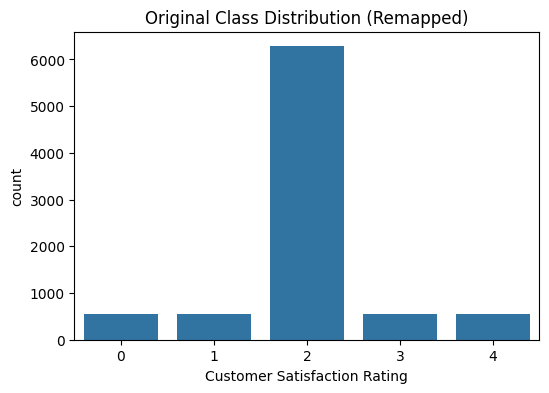

After SMOTE, class distribution:
Customer Satisfaction Rating
2    6280
0    6280
3    6280
4    6280
1    6280
Name: count, dtype: int64


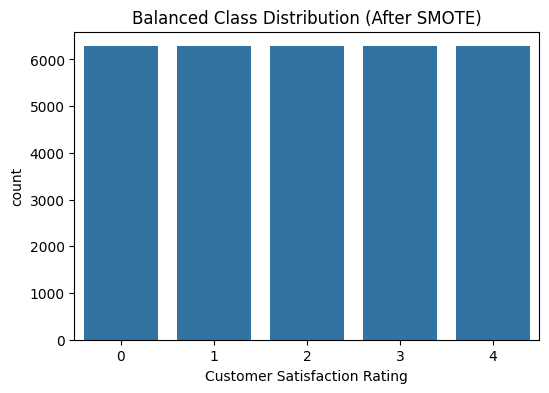

Training set shape: (25120, 11)
Test set shape: (6280, 11)
Random Forest Accuracy: 0.9617834394904459


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:47:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8770700636942675


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:47:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Ensemble Accuracy: 0.9195859872611465

📊 Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      1256
           1       0.89      0.94      0.91      1256
           2       0.99      0.92      0.95      1256
           3       0.92      0.91      0.91      1256
           4       0.97      0.85      0.91      1256

    accuracy                           0.92      6280
   macro avg       0.92      0.92      0.92      6280
weighted avg       0.92      0.92      0.92      6280

Ensemble model saved as: ensemble_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# %% [code]
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib  # for saving models
import pickle

# %% [code]
# 🚀 Upload your CSV dataset (from your local PC)
from google.colab import files

uploaded = files.upload()  # Select your CSV file when prompted
csv_filename = next(iter(uploaded))  # Get the filename

# %% [code]
# 📄 Load the dataset
df = pd.read_csv(csv_filename)
print("✅ Dataset loaded!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# %% [code]
# 🛠 Data Preprocessing

# Define the target column
target = 'Customer Satisfaction Rating'

# Remap target classes so that they start at 0.
# If your original classes are [1, 2, 3, 4, 5], subtract 1 to get [0, 1, 2, 3, 4]
df[target] = df[target] - 1

# Check for missing values (optional: handle as needed)
print("Missing values in each column:\n", df.isnull().sum())

# Identify categorical features (excluding the target)
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_features = [col for col in cat_features if col != target]
print("Categorical features:", cat_features)

# Use one-hot encoding for categorical features
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)
print("After encoding, dataset shape:", df_encoded.shape)

# %% [code]
# 🎯 Define features and target from the encoded dataset
X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

# %% [code]
# 📊 Plot the original class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title('Original Class Distribution (Remapped)')
plt.show()

# %% [code]
# ⚖️ Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("After SMOTE, class distribution:")
print(pd.Series(y_smote).value_counts())

# Plot the balanced class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_smote)
plt.title('Balanced Class Distribution (After SMOTE)')
plt.show()

# %% [code]
# 🔀 Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# %% [code]
# 🛠 Train Base Models: Random Forest and XGBoost

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

# Train an XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))

# Optionally: Display individual classification reports
#print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))
#print("\nXGBoost Classification Report:\n", classification_report(y_test, xgb_preds))

# %% [code]
# 👥 Ensemble Learning: Build an Ensemble using VotingClassifier (hard voting)
ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model)],
    voting='hard'
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate the ensemble on the test set
ensemble_preds = ensemble_model.predict(X_test)
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds))
print("\n📊 Ensemble Classification Report:\n", classification_report(y_test, ensemble_preds))

# %% [code]
# 💾 Save the Ensemble Model for Deployment
ensemble_model_path = 'ensemble_model.pkl'
joblib.dump(ensemble_model, ensemble_model_path)
print("Ensemble model saved as:", ensemble_model_path)

# %% [code]
# 🔽 Download the Ensemble Model to Your Local Machine
files.download(ensemble_model_path)


In [ ]:

print("Type of ensemble model:", type(ensemble_model))

if hasattr(ensemble_model, 'predict'):
    print("✅ The ensemble model has a 'predict' method.")
else:
    print("❌ The ensemble model does NOT have a 'predict' method.")


import joblib
ensemble_model = joblib.load('ensemble_model.pkl')
print("Loaded ensemble model type:", type(ensemble_model))

if hasattr(ensemble_model, 'predict'):
    print("✅ The loaded ensemble model has a 'predict' method.")
else:
    print("❌ The loaded ensemble model does NOT have a 'predict' method.")


Type of ensemble model: <class 'sklearn.ensemble._voting.VotingClassifier'>
✅ The ensemble model has a 'predict' method.
Loaded ensemble model type: <class 'sklearn.ensemble._voting.VotingClassifier'>
✅ The loaded ensemble model has a 'predict' method.
